# Example 1

This document shows the basic functionality of pySTAD.

In [1]:
import stad as sd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.spatial.distance import pdist

## The Data

For this notebook, we sample 300 data-points from a 3D horse-model.

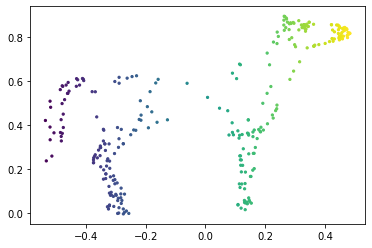

In [2]:
data = pd.read_csv('./data/horse.csv')
idx = np.random.choice(data.shape[0], 300, replace=False)
data = data.iloc[idx, :]
plt.scatter(data.z, data.y, s=5, c=data.z)
plt.show()

## Computing a STAD network

To compute a STAD network, we only have to supply the distances between data-points. STAD expects either a scipy sparse matrix, a scipy condensed matrix, or a dense distance matrix. In case of a sparse matrix, all upper-triangle values have to be explicit in the sparse matrix, even zero values. All other parameters have default values, and STAD will return enough information so we can verify whether the resulting graph is a good representation of the data.

In this example, we use the euclidean distance to compute the distance matrix:

In [3]:
dist = pdist(data, 'euclidean')
(network, sweep) = sd.stad(dist)

### Checking the output

By default, STAD tries to find the undirected and unweighted graph for which the distance between nodes in the graph correlate maximally with the supplied distance matrix. To inspect whether STAD found an acceptable solution, we plot the correlation of the networks STAD evaluated.

A trace of the optimisation effort is contained in the `sweeo` object returned by `sd.stad()`

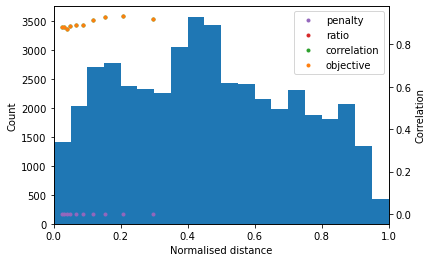

In [4]:
fig = sd.plot.sweep(dist, sweep)

This figure shows the correlations of the explored networks and a histogram of the normalized edge distances. By default, STAD performes a logarithmic sweep on the number of edges, where the $n$ shortest edges are included in the network. You can control this behaviour by configuring a sweep opbject and passing it as parameter to stad. 

The properties of the optimal network are also stored in the `sweep` object.

In [5]:
# The distance of the shortest edge that is NOT included in the network.
sweep.best_distance

0.20567131415634435

In [6]:
# The number of edges added to the MST to form the final network
sweep.best_added_edges

8921

In [7]:
# The correlation of the distances in the final network with the distances in the data.
sweep.best_correlation

0.9325409284296015

In [8]:
# The objective value of the final netwok. This may be different from the correlation
# when the optimization is configured manually.
sweep.best_objective

0.9325409284296015

### The penalty parameter

Sometimes, it is preferable to reduce the number of edges in the network without sacraficing much correlation. For that scenario, STAD implements a penalty parameter. This parameter penalises a network based on its number of edges. Like a weight-decay for neural networks, it balances the quality of the solution with its complexity.

Using this parameter, it is possible to reduce the number of edges in the network. Internally the optimisation objective is computed as:
    $correlation - penalty * (added\_edges / maximum\_edges)$

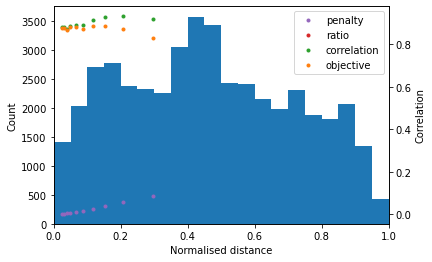

In [9]:
(network_penalty, sweep) = sd.stad(dist, edge_penalty=0.3)
sd.plot.sweep(dist, sweep)
plt.show()

Now, the orange dots indicate the objective, which is used to determine the optimal network:

In [10]:
sweep.best_distance

0.11849200714611824

In [11]:
sweep.best_added_edges

4031

In [12]:
sweep.best_objective

0.8873435932032245

This network has roughly 2000 less edges than the one without penalty.

## The ratio parameter

Sometimes, when the distance distribution is left skewed, the correlation curve does not have a clear peak. Then, one can add a ratio penalty term to the objective: $ratio = \frac{\sum_{edge}{1 - d_{edge}}}{\sum_{edge}{1 + d_{edge}}}$ and $objective = ratio * correlation$

(*this is not a very good example of when to use the ratio term*)

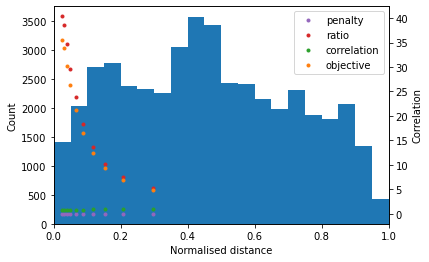

In [13]:
(network_ratio, sweep) = sd.stad(dist, use_ratio=True)
sd.plot.sweep(dist, sweep)
plt.show()

In this example the ratio value is so large that the correlation does not have much influence anymore, but in other data-sets this option can reduce the number of edges while maintaining a high correlation value.

## Visualising the output

STAD provides a drawing function build upon NetworkX and Matplotlib. The function supports several of the networkx layouts.

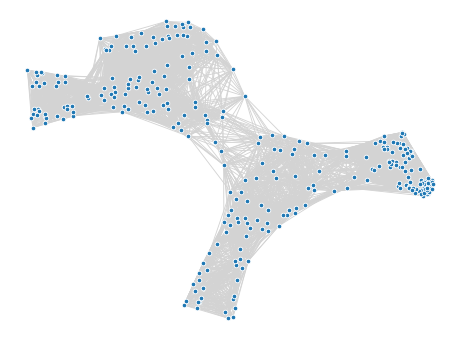

In [14]:
fig = plt.figure(figsize=(8, 6))
fig, nodes, edge, graph, layout = sd.plot.network(network, layout = 'kk',
                                                  ax = plt.gca())
plt.show()

The function returns several items:
- the matplotlib figure
- the networkx nodes object
- the networkx edges object
- the networkx graph
- the networkx layout

These can be used to customise the figure, or to draw another figure using the same layout.

Colouring the vertices is possible with nodex arguments `node_color`, `cmap`, `vmin`, and `vmax`.

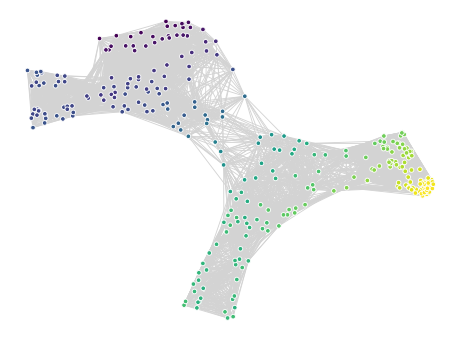

In [15]:
fig = plt.figure(figsize=(8, 6))
_ = sd.plot.network(network, layout = 'kk', cmap = 'viridis', node_color = data.z, ax = plt.gca())
plt.show()

One can use the layout of a previous plot again, by passing it to the `positions` argument. In that case, the `layout` argument is ignored.

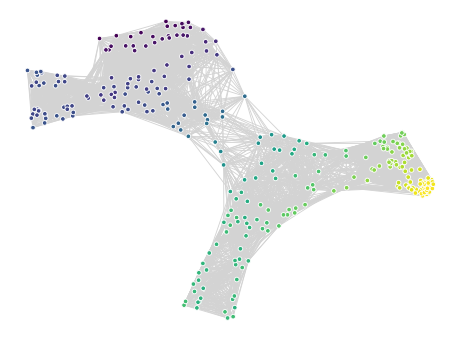

In [16]:
fig = plt.figure(figsize=(8, 6))
_ = sd.plot.network(network, cmap='viridis', node_color = data.z, ax=plt.gca(),
                    positions = layout)           
plt.show()

The positions argument also accepts custom `positions` in the form of a 2D numpy array:

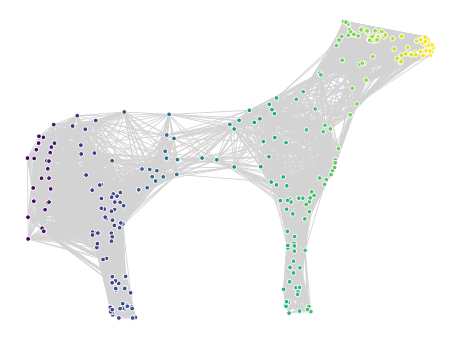

In [17]:
fig = plt.figure(figsize=(8, 6))
_ = sd.plot.network(network, cmap='viridis', node_color = data.z, positions=data[['z','y']].to_numpy(), ax=plt.gca())
plt.show()

### Interpreting a STAD graph

Unlike the figures of other dimensionality reduction algorithms, the position of nodes in the figure do not have meaning. Only the connectivity between nodes is important. Consequently, one has a lot of freedom when drawing a STAD graph. Drawing algorithms then to prioritise legibility of the networks rather than preserving distances, so one should take care when comparing positions. However, force-based drawing layouts tend to preserve local neighbourhood clusters.

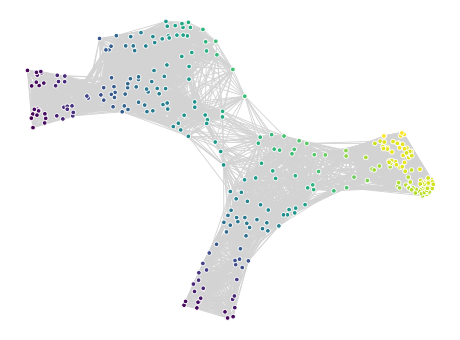

In [18]:
fig = plt.figure(figsize=(8, 6))
_ = sd.plot.network(network, cmap='viridis', node_color = data.y, ax = plt.gca(), positions=layout)        
plt.show()

Important features of a STAD network are loops and flares. Loops typicaly occur when modeling periodic patterns. Flares indicate groups of points that are different from the other parts of the dataswet. In this figure, there are three main flares. One for the head (yellow), one for the front-legs, and one for the back legs. 

To explore how points in the graph differ, one could map the underlying dimensions to node colours and sizes, or use the interactive visualization widget explained in Example 3.

## Further remarks

See `help(sd)` for more information!

In [19]:
help(sd)

Help on package stad:

NAME
    stad - pySTAD - a python implementation of STAD.

DESCRIPTION
    STAD is a dimensionality reduction algorithm, that generates an abstract
    representation of high-dimensional data by giving each data point a location
    in a graph which preserves the distances in the original high-dimensional
    space. The STAD graph is built upon a Minimum Spanning Tree (MST) to
    which new edges are added until the correlation between the graph and the
    original dataset is maximized. Additionally, STAD supports the inclusion
    of filter functions to analyse data from new perspectives, emphasizing
    traits in data which otherwise would remain hidden.
    
    This package contains an implementation of STAD and provides interactive
    visualization functionality.
    
    Functions
    ---------
    stad : 
      The main function for creating a STAD network: 
        `network, sweep = stad(distance_matrix, [lens = Lens, sweep = Sweep])`
      Where lens i